# Book Data Linkage Statistics

This notebook presents statistics of the book data integration.

## Setup

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

## Load Link Stats

We compute dataset linking statitsics as `gender-stats.csv` using DataFusion.  Let's load those:

In [2]:
link_stats = pd.read_csv('book-links/gender-stats.csv')
link_stats.head()

,dataset,gender,n_books,n_actions
0,BX-E,ambiguous,4953,39734
1,BX-E,no-book-author,5613,7614
2,BX-E,no-author-rec,6707,8474
3,BX-E,unknown,15234,24639
4,BX-E,no-book,20075,23084


Now let's define variables for our variou codes. We are first going to define our gender codes.  We'll start with the resolved codes:

In [3]:
link_codes = ['female', 'male', 'ambiguous', 'unknown']

We want the unlink codes in order, so the last is the first link failure:

In [4]:
unlink_codes = ['no-author-rec', 'no-book-author', 'no-book']

In [5]:
all_codes = link_codes + unlink_codes

## Processing Statistics

Now we'll pivot each of our count columns into a table for easier reference.

In [6]:
book_counts = link_stats.pivot('dataset', 'gender', 'n_books')
book_counts = book_counts.reindex(columns=all_codes)
book_counts.assign(total=book_counts.sum(axis=1))

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book,total
dataset,,,,,,,,
AZ,236107.0,521692.0,20936.0,226787.0,157850.0,113652.0,985503.0,2262527.0
BX-E,39486.0,57107.0,4953.0,15234.0,6707.0,5613.0,20075.0,149175.0
BX-I,69575.0,99655.0,8391.0,31385.0,13620.0,11350.0,40633.0,274609.0
GR-E,213527.0,315282.0,15824.0,98849.0,54335.0,787097.0,NaN,1484914.0
GR-I,215584.0,319163.0,15986.0,100566.0,55383.0,799783.0,NaN,1506465.0
LOC-MDS,731452.0,2377946.0,67925.0,1114542.0,333270.0,609387.0,NaN,5234522.0


In [7]:
act_counts = link_stats.pivot('dataset', 'gender', 'n_actions')
act_counts = act_counts.reindex(columns=all_codes)
act_counts.drop(index='LOC-MDS', inplace=True)
act_counts

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,4732152.0,6820525.0,779436.0,2021804.0,1009603.0,1278813.0,5798466.0
BX-E,142359.0,181305.0,39734.0,24639.0,8474.0,7614.0,23084.0
BX-I,400793.0,460256.0,99391.0,69693.0,22414.0,20420.0,56245.0
GR-E,36503691.0,33434112.0,12307985.0,3520408.0,1158513.0,12294989.0,NaN
GR-I,82564350.0,69969612.0,20242905.0,9820418.0,3670748.0,33273918.0,NaN


We're going to want to compute versions of this table as fractions, e.g. the fraction of books that are written by women.  We will use the following helper function:

In [8]:
def fractionalize(data, columns, unlinked=None):
    fracs = data[columns]
    fracs.columns = fracs.columns.astype('str')
    if unlinked:
        fracs = fracs.assign(unlinked=data[unlinked].sum(axis=1))
    totals = fracs.sum(axis=1)
    return fracs.divide(totals, axis=0)

And a helper function for plotting bar charts:

In [9]:
def plot_bars(fracs, ax=None, cmap=mpl.cm.Dark2):
    if ax is None:
        ax = plt.gca()
    size = 0.5
    ind = np.arange(len(fracs))
    start = pd.Series(0, index=fracs.index)
    for i, col in enumerate(fracs.columns):
        vals = fracs.iloc[:, i]
        rects = ax.barh(ind, vals, size, left=start, label=col, color=cmap(i))
        for j, rec in enumerate(rects):
            if vals.iloc[j] < 0.1 or np.isnan(vals.iloc[j]): continue
            y = rec.get_y() + rec.get_height() / 2
            x = start.iloc[j] + vals.iloc[j] / 2
            ax.annotate('{:.1f}%'.format(vals.iloc[j] * 100),
                        xy=(x,y), ha='center', va='center', color='white',
                        fontweight='bold')
        start += vals.fillna(0)
    ax.set_xlabel('Fraction of Books')
    ax.set_ylabel('Data Set')
    ax.set_yticks(ind)
    ax.set_yticklabels(fracs.index)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Resolution of Books

What fraction of *unique books* are resolved from each source?

In [10]:
fractionalize(book_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,0.104355,0.230579,0.009253,0.100236,0.069767,0.050232,0.435576
BX-E,0.264696,0.382819,0.033203,0.102122,0.044961,0.037627,0.134573
BX-I,0.253360,0.362898,0.030556,0.114290,0.049598,0.041331,0.147967
GR-E,0.143798,0.212323,0.010657,0.066569,0.036591,0.530062,NaN
GR-I,0.143106,0.211862,0.010612,0.066756,0.036764,0.530900,NaN
LOC-MDS,0.139736,0.454281,0.012976,0.212921,0.063668,0.116417,NaN


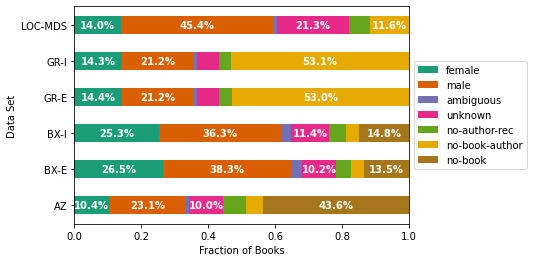

In [11]:
plot_bars(fractionalize(book_counts, link_codes + unlink_codes))

In [12]:
fractionalize(book_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
AZ,0.104355,0.230579,0.009253,0.100236,0.555576
BX-E,0.264696,0.382819,0.033203,0.102122,0.217161
BX-I,0.253360,0.362898,0.030556,0.114290,0.238896
GR-E,0.143798,0.212323,0.010657,0.066569,0.566654
GR-I,0.143106,0.211862,0.010612,0.066756,0.567664
LOC-MDS,0.139736,0.454281,0.012976,0.212921,0.180085


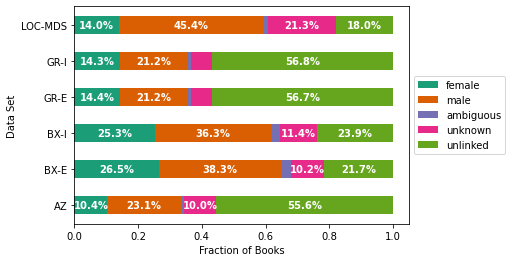

In [13]:
plot_bars(fractionalize(book_counts, link_codes, unlink_codes))

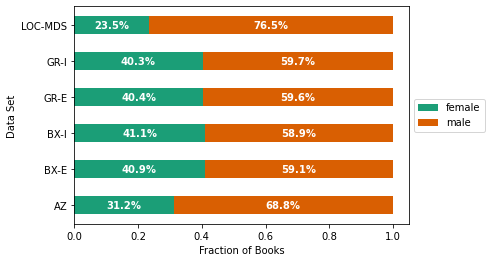

In [14]:
plot_bars(fractionalize(book_counts, ['female', 'male']))

## Resolution of Ratings

What fraction of *rating actions* have each resolution result?

In [15]:
fractionalize(act_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,0.210873,0.303934,0.034733,0.090095,0.044990,0.056986,0.258389
BX-E,0.333230,0.424394,0.093008,0.057674,0.019836,0.017823,0.054034
BX-I,0.354932,0.407590,0.088018,0.061718,0.019849,0.018083,0.049809
GR-E,0.367908,0.336971,0.124048,0.035481,0.011676,0.123917,NaN
GR-I,0.376076,0.318707,0.092205,0.044731,0.016720,0.151561,NaN


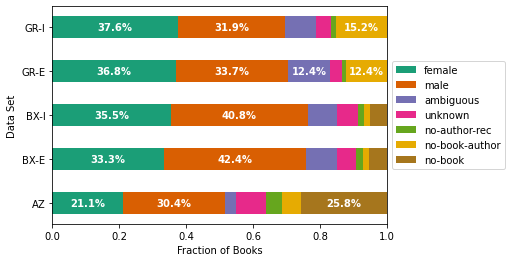

In [16]:
plot_bars(fractionalize(act_counts, link_codes + unlink_codes))

In [17]:
fractionalize(act_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
AZ,0.210873,0.303934,0.034733,0.090095,0.360365
BX-E,0.333230,0.424394,0.093008,0.057674,0.091693
BX-I,0.354932,0.407590,0.088018,0.061718,0.087742
GR-E,0.367908,0.336971,0.124048,0.035481,0.135593
GR-I,0.376076,0.318707,0.092205,0.044731,0.168281


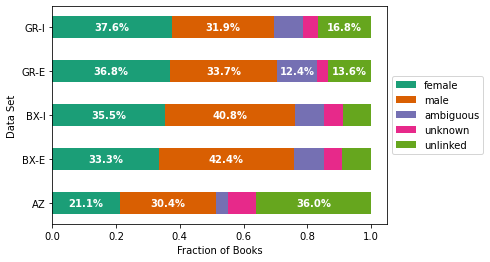

In [18]:
plot_bars(fractionalize(act_counts, link_codes, unlink_codes))

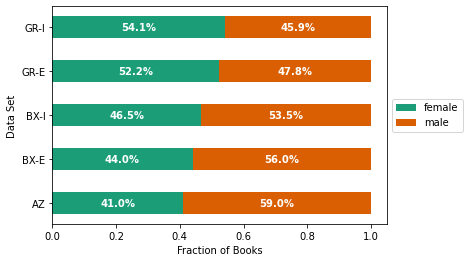

In [19]:
plot_bars(fractionalize(act_counts, ['female', 'male']))

## Metrics

Finally, we're going to write coverage metrics.

In [20]:
book_tots = book_counts.sum(axis=1)
book_link = book_counts['male'] + book_counts['female'] + book_counts['ambiguous']
book_cover = book_link / book_tots
book_cover

dataset
AZ         0.344188
BX-E       0.680717
BX-I       0.646814
GR-E       0.366777
GR-I       0.365580
LOC-MDS    0.606994
dtype: float64

In [21]:
book_cover.to_json('book-coverage.json')